# Filtering

The instability of RSSI based requires the application of some filter algorithms. Here, we describe and apply the filters selected to the data set obtained. Specifically, wepresent a brief explanation of the theory behind each filter, the related function implementation,and an evaluation of their performance. Finally, a comparison between the different filtered valuesis proposed.

Importing libraries and reading the downsampled data.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
df = pd.read_csv('../dataset/resample_mean.csv')

## Grey Filter

Grey filters are based on the grey system theory, an interdisciplinary scientific area introduced byJulong Deng at the Huazhong University of Science and Technology in 1982.  In system theory,a system can be defined with a color representing the amount of clear information about it.  Acompletely unknown system is defined as a black system, while a white system is a completelyknown one. Similarly, systems with both known and unknown information are referred to as greysystems, representing the most common case since there are always some uncertainties in the realworld.  In this context, we define the grey models as models that can estimate the behavior of anunknown system only using a limited amount of data.  Precisely, they can predict the values offuture data based only on a set of the most recent data using a curve fitting approach.

In [3]:
# Grey filter taking in input the signal to filter, the time index and the windows size
# Return the filtered signal

def grey_filter(signal, index, N):
    filtered_signal = []

    # iterates on the entire signal, taking steps by window size
    for j in range(0, np.shape(signal)[0], N):    

        # just in case we are at signal final and N samples are not available
        N = np.minimum(N, np.shape(signal)[0]-j)  

        # saves in R_0 signal values of corresponding window size
        R_0 = np.zeros(N)
        R_0[:] = signal[j:j+N]                     
        
        # calculates R_1
        R_1 = []
        for i in range(N):
            R_1.append((np.cumsum(R_0[0:i+1]))[i])  

        # calculates grey filter solution
        B = (np.matrix([np.ones((N-1)), np.ones((N-1))])).T
        for k in range(N-1):
            B[k, 0] = -0.5 * (R_1[k+1] + R_1[k])

        X_n = np.matrix(np.asarray(R_0[1:])).T
        _ = np.matmul(np.linalg.pinv(
                np.matmul(B.T, B)),
                      (np.matmul(B.T, X_n)))
        
        a = _[0, 0]
        u = _[1, 0]

        # updates predicted signal with window calculations
        X_ = R_0[0]
        filtered_signal.append(X_)
        for i in range(1, N):                                             
            filtered_signal.append((((R_0[0] - u/a) * np.exp(-a * (i - 1)))*(1 - np.exp(a))))
    
    # transforms the data into dataframe with the time index
    df_filtered = pd.DataFrame(filtered_signal, columns=['rssi'])
    df_filtered = df_filtered.join(index)
        
    return df_filtered

In [4]:
grey_filtered = grey_filter(df['rssi'], df['Time'], N=5)
grey_filtered.head()

,rssi,Time
0,-88.250000,2022-09-05 15:24:54
1,-88.218564,2022-09-05 15:24:56
2,-87.771991,2022-09-05 15:24:58
3,-87.327679,2022-09-05 15:25:00
4,-86.885616,2022-09-05 15:25:02


<AxesSubplot:title={'center':'Grey filter'}, xlabel='Time', ylabel='RSSI'>

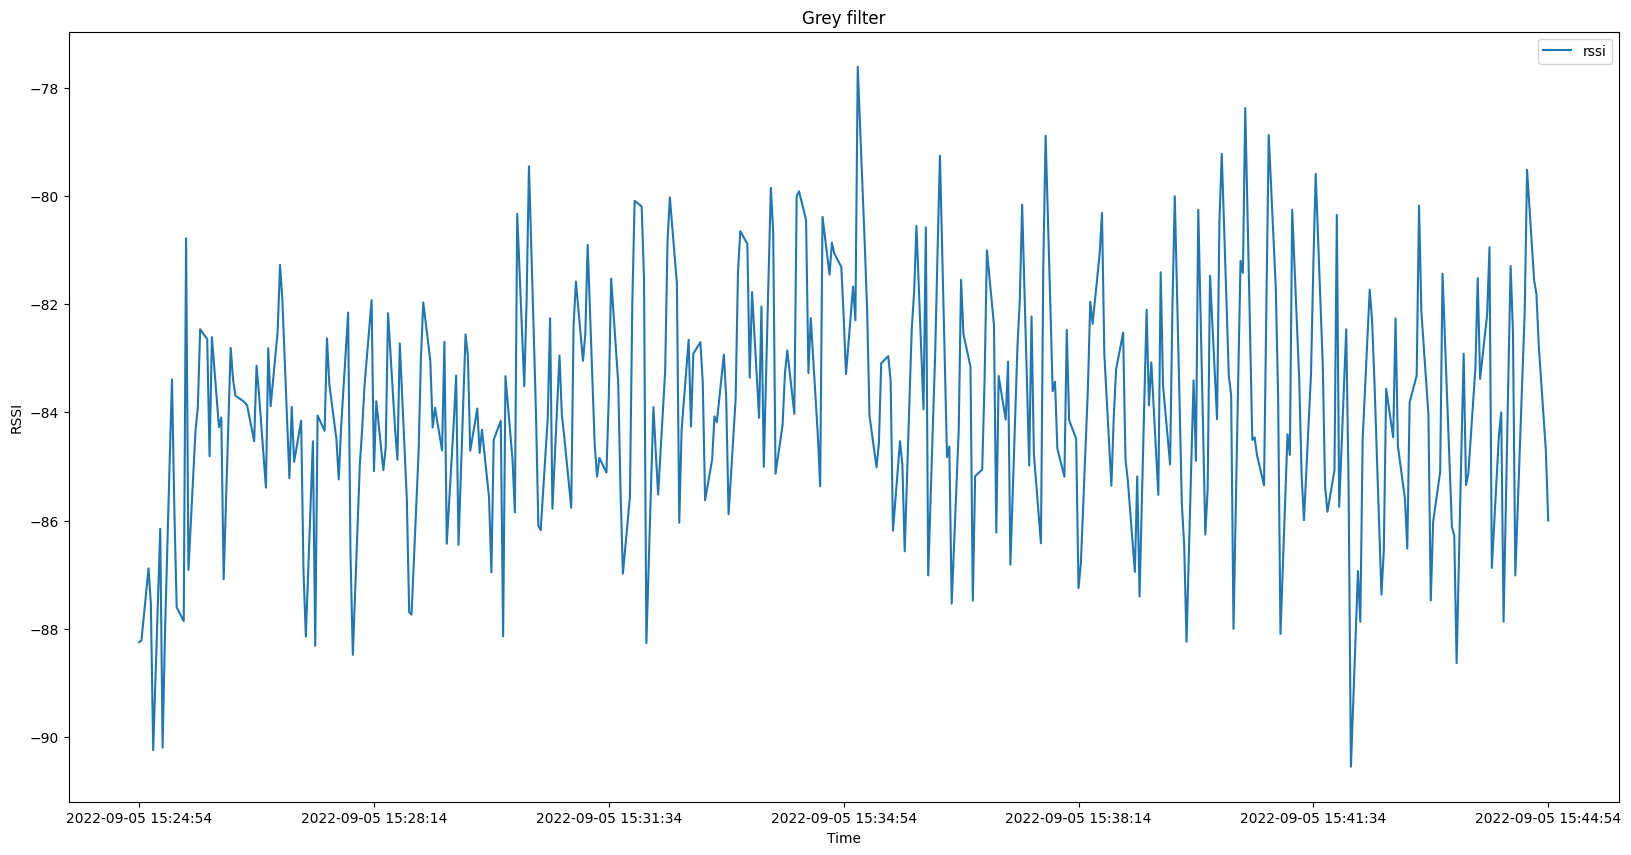

In [5]:
grey_filtered.plot(x='Time',xlabel='Time', y='rssi', ylabel='RSSI', title='Grey filter', figsize=(20, 10))

We compare the filtered values obtained with the grey filter function with the raw data.

Text(0, 0.5, 'RSSI')

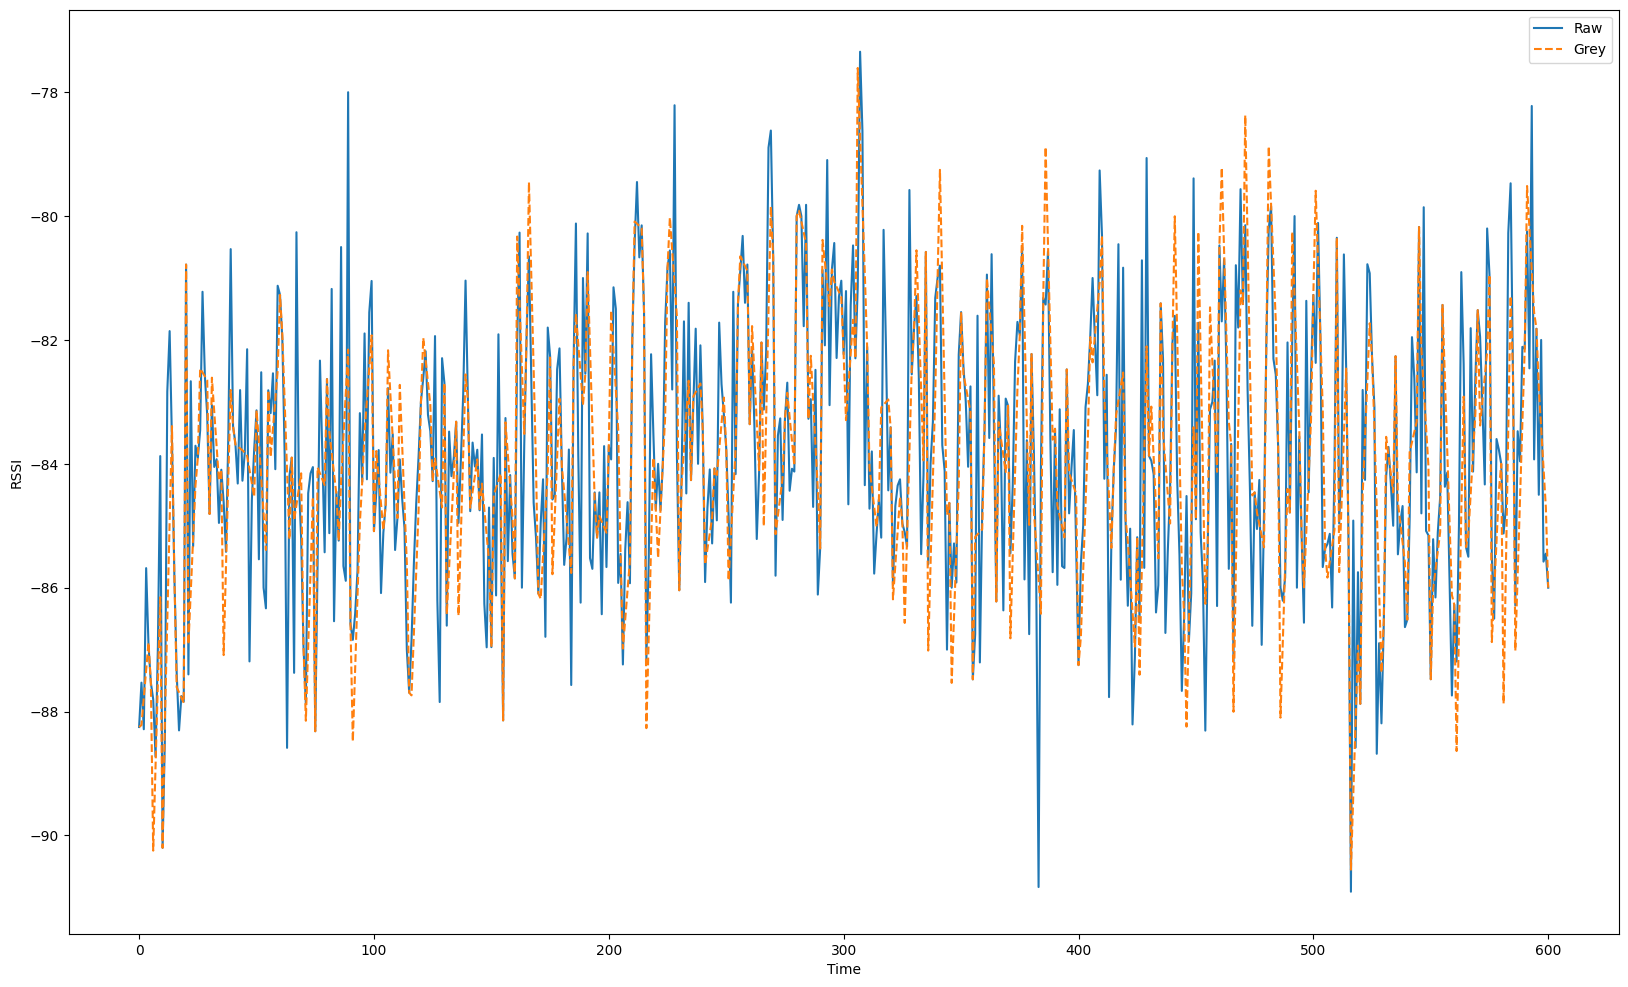

In [6]:
plt.figure(figsize=(20, 12))

plt.plot(df['rssi'], label='Raw')
plt.plot(grey_filtered['rssi'], label='Grey', linestyle='dashed')

plt.legend()
plt.xlabel('Time')
plt.ylabel('RSSI')

The figure shows that the grey filter is able to reduce the fluctuation, especially when there are high or low peaks. However, the filter is sensitive to quick changes in data since the line still has significant fluctuations and even some new ones.

## Kalman Filter

The Kalman filter was invented by Rudolf Emil Kálmán at the Research Institute for Advanced Study in 1960 to solve the discrete-data linear filtering problems in a mathematically optimal way.
The first use of the Kalman filter was on the Apollo missions, and since then, it has been used in an enormous variety of domains. The relative simplicity and robust nature of the filter have ensured the success of the Kalman filter.
The Kalman filter is essentially a set of mathematical equations that implement an optimal predictor-corrector type estimator. The term optimal is used because the function minimizes the estimated error covariance when some presumed conditions are met.
The Kalman filter exploits the target dynamics, i.e., its time evolution, to remove the effects of noise.

In [7]:
# Kalman filter taking in input the signal to filter, the time index and the filter parameters
# Return the filtered signal

def kalman_block(x, P, s, A, H, Q, R):
    x_mean = A * x + np.random.normal(0, Q, 1)
    P_mean = A * P * A + Q

    K = P_mean * H * (1 / (H * P_mean * H + R))
    x = x_mean + K * (s - H * x_mean)
    P = (1 - K * H) * P_mean

    return x, P

def kalman_filter(signal, index, A, H, Q, R):
    filtered_signal = []
    # takes first value as first filter prediction
    x = signal[0]
    # sets first covariance state value to zero
    P = 0                                         

    filtered_signal.append(x)
    # iterates on the entire signal, except the first element
    for j, s in enumerate(signal[1:]):            
        # calculates next state prediction
        # x: previous mean state
        # P: previous covariance state
        # s: current observation
        x, P = kalman_block(x, P, s, A, H, Q, R)
        # updates predicted signal with this step calculation
        filtered_signal.append(x[0])

    df_filtered = pd.DataFrame(filtered_signal, columns=['rssi'])
    df_filtered = df_filtered.join(index)

    return df_filtered

In [8]:
kalman_filtered = kalman_filter(df['rssi'], df['Time'],  A=1, H=1, Q=1.6, R=6)
kalman_filtered.head()

,rssi,Time
0,-88.250000,2022-09-05 15:24:54
1,-89.146355,2022-09-05 15:24:56
2,-87.878532,2022-09-05 15:24:58
3,-87.454170,2022-09-05 15:25:00
4,-87.536688,2022-09-05 15:25:02


<AxesSubplot:title={'center':'Kalman filter'}, xlabel='Time', ylabel='RSSI'>

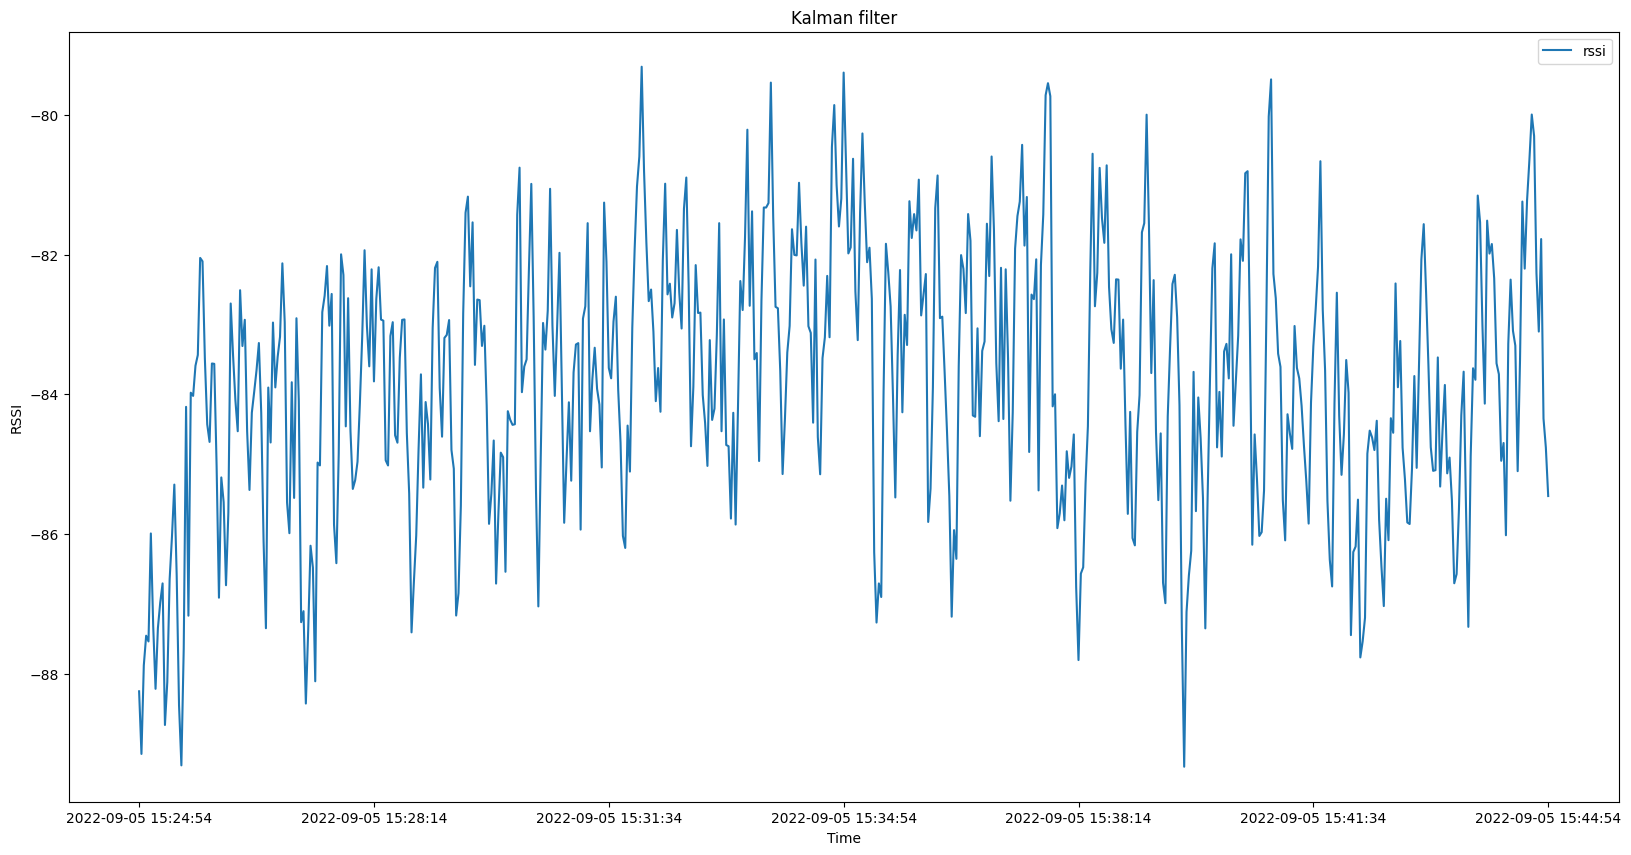

In [9]:
kalman_filtered.plot(x='Time',xlabel='Time', y='rssi', ylabel='RSSI', title='Kalman filter', figsize=(20, 10))

We compare the filtered values obtained with the Kalman filter function with the raw data.

Text(0, 0.5, 'RSSI')

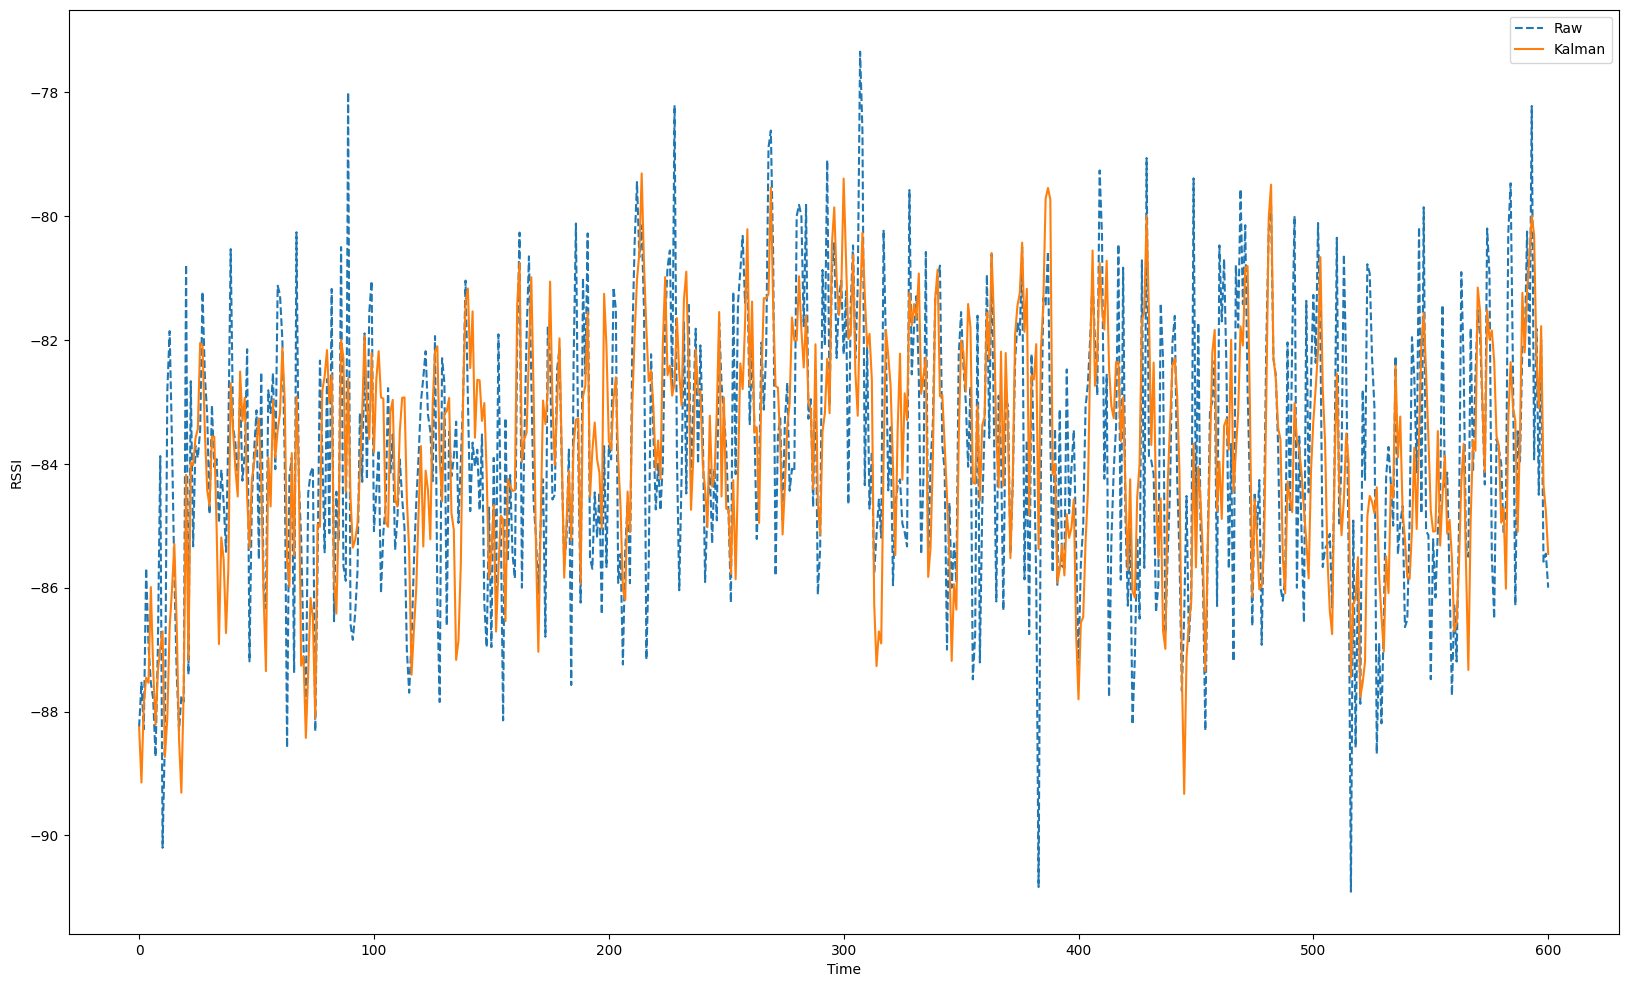

In [10]:
plt.figure(figsize=(20, 12))

plt.plot(df['rssi'], linestyle='dashed', label='Raw')
plt.plot(kalman_filtered['rssi'], label='Kalman')

plt.legend()
plt.xlabel('Time')
plt.ylabel('RSSI')

The Kalman filter provides a good fluctuations mitigation and is able to follow the time evolution without amplifying many rapid changes in the values

## Fourier filter

The Fourier filter is a filtering function used in signal processing based on manipulating specific frequency components of a signal exploiting the Fourier transform. A Fourier transform is
a mathematical transform that decomposes functions depending on space or time into functions depending on spatial or temporal frequency. However, the Fourier transform requires a considerable number of operations making the computation prohibitively expensive. The Fast Fourier transform addresses this problem, reducing the complexity introducing a memory portion within the algorithm.

In [11]:
# Fourier filter taking in input the signal to filter, the time index, the windows size
# and the number of sample to preserve
# Return the filtered signal

def fft_filter(signal, index, N, M):
    filtered_signal = []

    for j in range(0, np.shape(signal)[0], N):      
        # just in case we are at signal final and N samples are not avail
        N = np.minimum(N, np.shape(signal)[0] - j)  

        # saves in R_0 signal values of corresponding window size
        R_0 = np.zeros(N)
        R_0[:] = signal[j:j+N]                       

        # fft of signal window
        R_0_fft = np.fft.fft(R_0)                    

        # it keeps M samples of fft and sets the rest to zero
        # remembers fft symmetry
        for k in range(int(N / 2)):                    
            R_0_fft[M+k] = 0                         
            R_0_fft[-1-M-k] = 0

        # inverse fft
        R_0_ifft = np.fft.ifft(R_0_fft)              

        # updates predicted signal with this window calculation
        for i in range(0, N):
            filtered_signal.append(R_0_ifft[i])     

    df_filtered = pd.DataFrame(filtered_signal, columns=['rssi'])
    df_filtered = df_filtered.join(index)

    return df_filtered

In [12]:
fft_filtered = fft_filter(df['rssi'], df['Time'], N=6, M=2)
fft_filtered.head()

,rssi,Time
0,-87.784524-0.195887j,2022-09-05 15:24:54
1,-87.746502+0.261743j,2022-09-05 15:24:56
2,-87.331172+0.457630j,2022-09-05 15:24:58
3,-86.953864+0.195887j,2022-09-05 15:25:00
4,-86.991886-0.261743j,2022-09-05 15:25:02


<AxesSubplot:title={'center':'Fourier filter'}, xlabel='Time', ylabel='RSSI'>

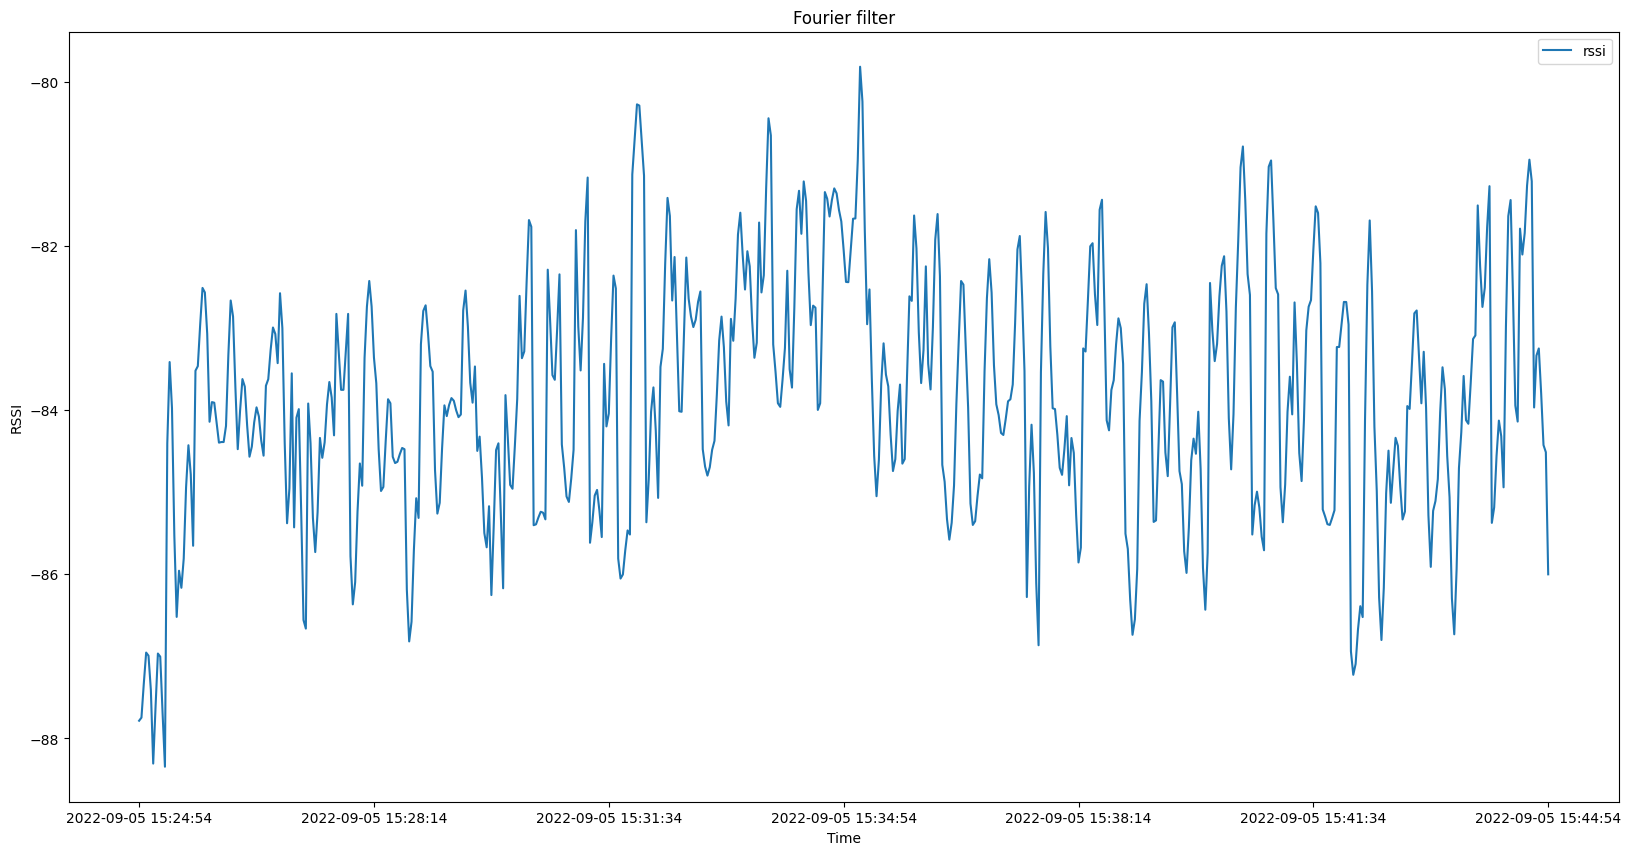

In [13]:
fft_filtered.plot(x='Time',xlabel='Time', y='rssi', ylabel='RSSI', title='Fourier filter', figsize=(20, 10))

We compare the filtered values obtained with the Fourier filter function with the raw data.

Text(0, 0.5, 'RSSI')

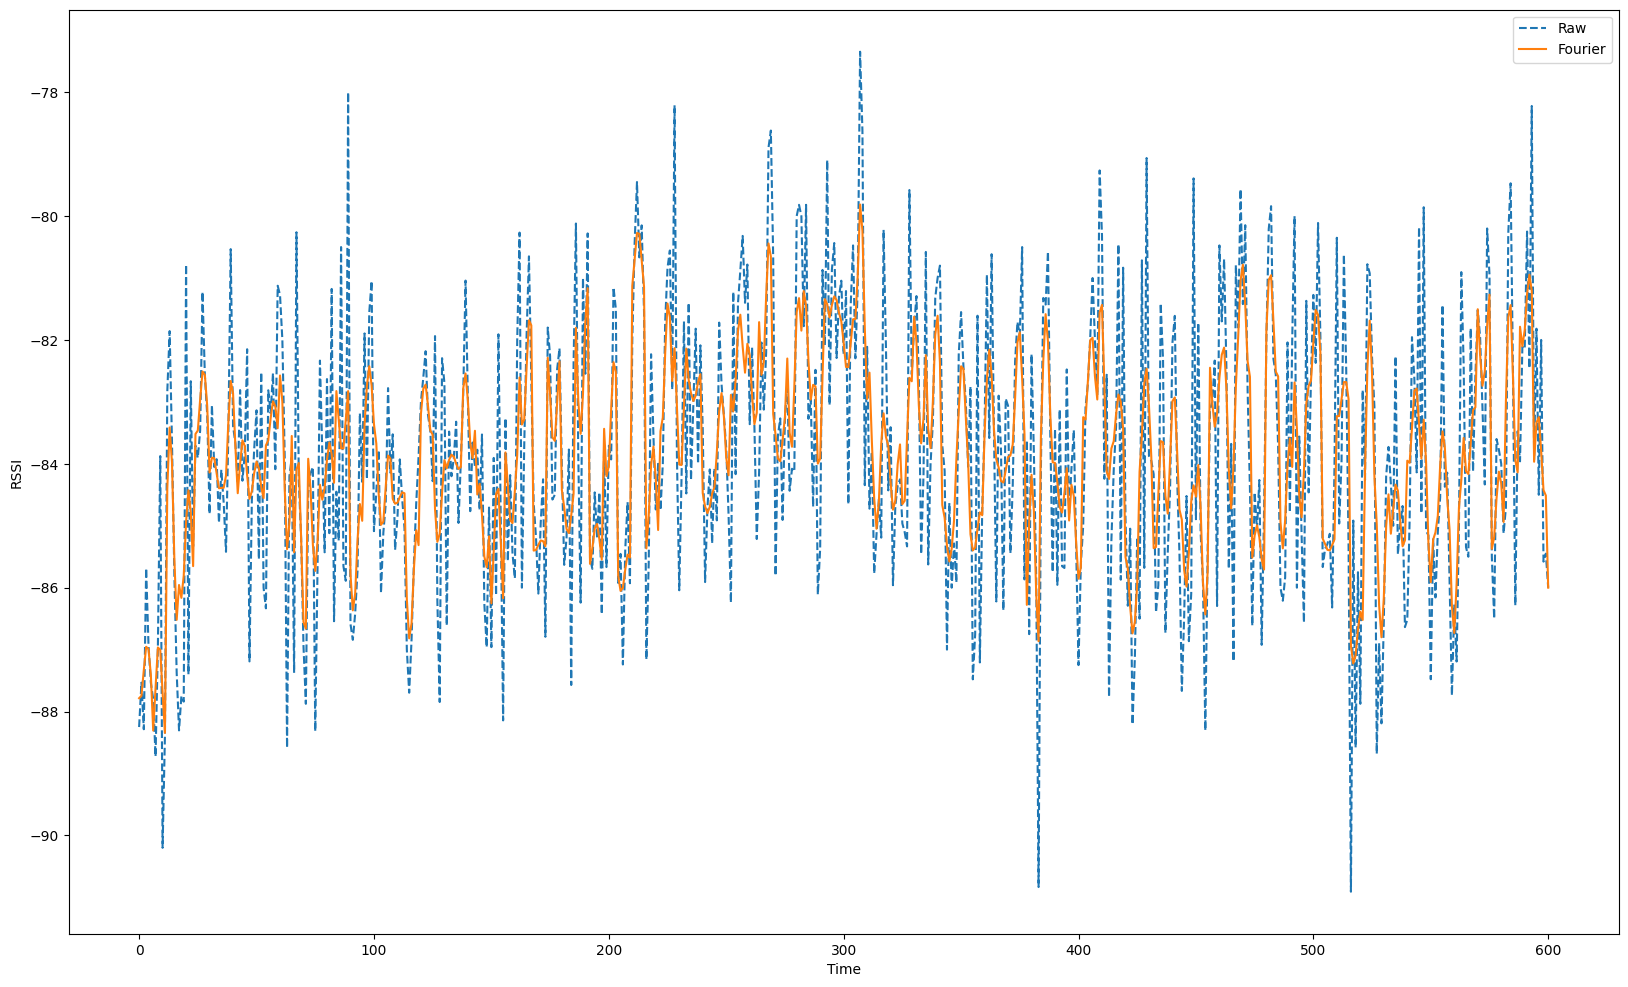

In [14]:
plt.figure(figsize=(20, 12))

plt.plot(df['rssi'], linestyle='dashed', label='Raw')
plt.plot(fft_filtered['rssi'], label='Fourier')

plt.legend()
plt.xlabel('Time')
plt.ylabel('RSSI')

The Fourier filter provides a significantly smoother line than the raw data reducing the fluctuations and following the time sequence without any amplification of the signal.

## Particle filter

Particle filters are algorithms used to solve filtering problems arising in signal processing and Bayesian statistical inference. The term particle filters were first coined in 1996 by Del Moral in reference to mean-field interacting particle methods used in fluid mechanics since the beginning of the 1960s.
Particle filters use a set of particles, also called samples, to represent the posterior distribution of some stochastic process given noisy or partial observations. Each particle has a weight representing the probability of being sampled from the probability function. In the resampling step, the particles with negligible weights are replaced by new particles in the proximity of the particles with higher weights.

In [15]:
# Particle filter taking in input the signal to filter, the time index, the number of particles,
# and the filter parameters
# Return the filtered signal

def choose_particle(particles):
    prob_distribution = []

    # calculates sum of weights to normalize wheight vector in next step
    sum_weights = 0
    for p in particles:
        sum_weights += p['weight']

    for p in particles:
        prob_distribution.append(float(p['weight'] / sum_weights))

    # choose particle according to weights distribution
    a = np.random.choice(particles, 1, replace=False, p=prob_distribution)

    return a[0]['value'][0]


def particle_filter(signal, index, quant_particles, A, H, Q, R):

    filtered_signal = []
    # variation range of particles for initial step
    rang = 10                                                  
    # takes first value as first filter prediction
    x = signal[0]                                              
    # sets first covariance state value to zero
    P = 0                                                      

    filtered_signal.append(x)
    # defines some needed constants in algorithm
    min_weight_to_consider = 0.07                              
    min_weight_to_split_particle = 5

    # iterates on the entire signal, except the first element
    for j, s in enumerate(signal[1:]):                         
        # sets variation range for first step sampling
        range_ = [filtered_signal[j-1] - rang,
        filtered_signal[j-1] + rang]                

        particles = []
        # loop on all particles
        for particle in range(quant_particles):                
            # sample particle value from variation range
            input = np.random.uniform(range_[0], range_[1])
            # particle weight
            weight = 1 / np.abs(input-x)                       

            # it only iterates on particles which weights are greater than _min_weight_to_consider_
            if weight > min_weight_to_consider:
                # calculates next state prediction
                x_, P = kalman_block(input, P, s, A, H, Q, R)  

                # prediction weight
                weight = 1 / np.abs(s - x_)                    
                particles.append({'value': x_, 'weight': weight})

                # for particles with greater weights, it creates other particles in the 'neighborhood'
                if weight > min_weight_to_split_particle:

                    input = input + np.random.uniform(0, 5)
                    x_, P = kalman_block(input, P, s, A, H, Q, R)

                    weight = 1 / np.abs(s - x_)
                    particles.append({'value': x_, 'weight': weight})

        # chooses a particle, according to weight distribution
        x = choose_particle(particles)                      

        # updates predicted signal with this step calculation
        filtered_signal.append(x)                             

    df_filtered = pd.DataFrame(filtered_signal, columns=['rssi'])
    df_filtered = df_filtered.join(index)

    return df_filtered

In [16]:
particle_filtered = particle_filter(df['rssi'], df['Time'], quant_particles=1000, A=1, H=1, Q=1.6, R=6)
particle_filtered.head()

,rssi,Time
0,-88.250000,2022-09-05 15:24:54
1,-91.115568,2022-09-05 15:24:56
2,-88.921196,2022-09-05 15:24:58
3,-85.408635,2022-09-05 15:25:00
4,-88.169113,2022-09-05 15:25:02


<AxesSubplot:title={'center':'Particle filter'}, xlabel='Time', ylabel='RSSI'>

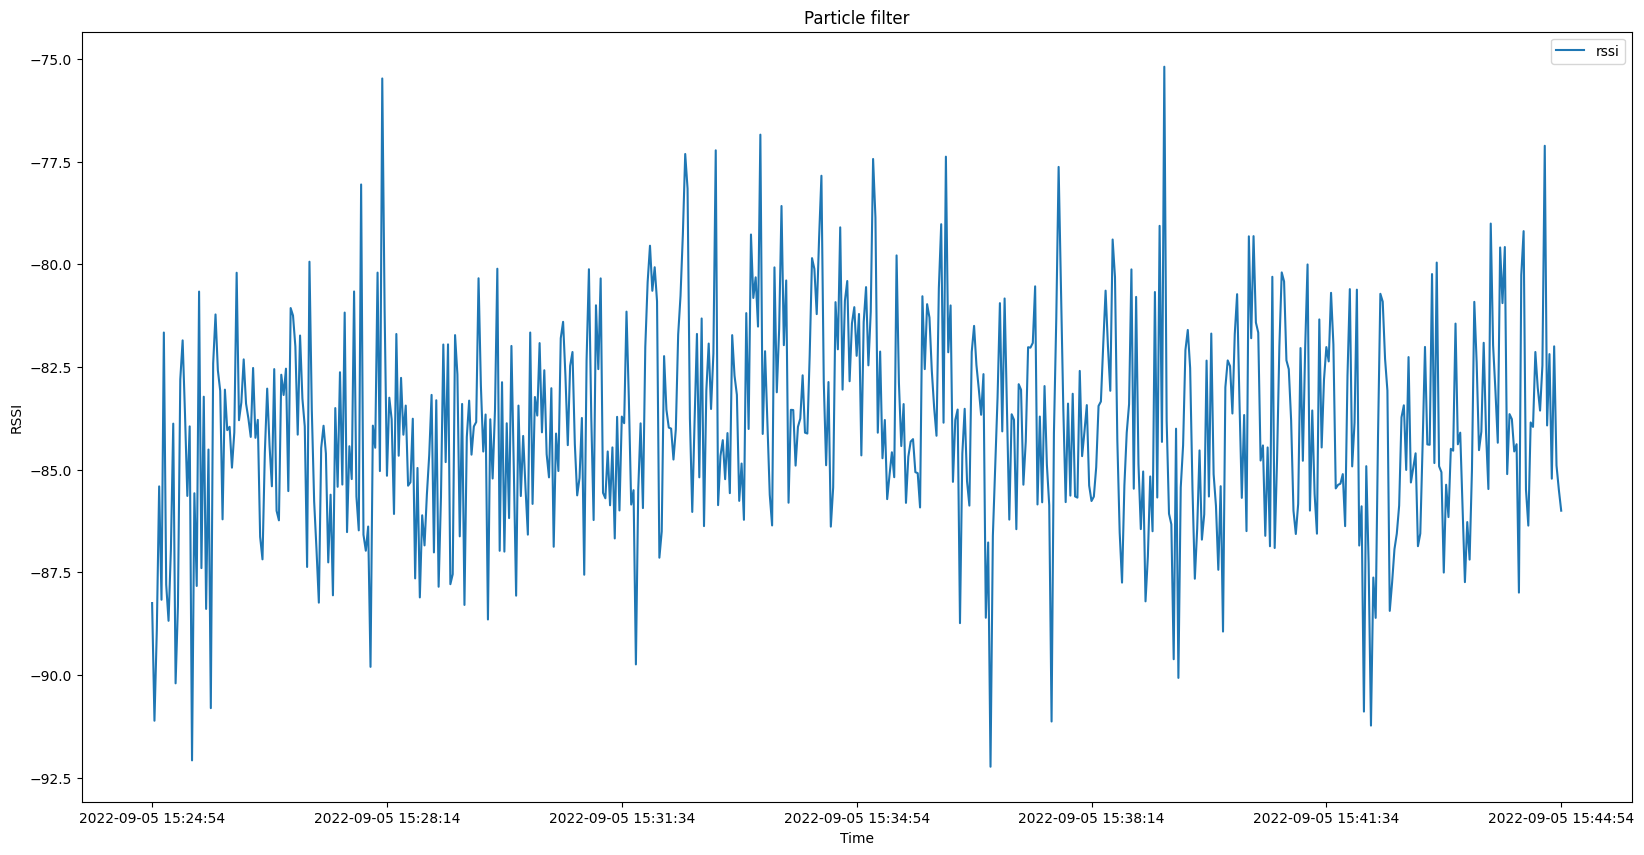

In [17]:
particle_filtered.plot(x='Time',xlabel='Time', y='rssi', ylabel='RSSI', title='Particle filter', figsize=(20, 10))

We compare the filtered values obtained with the particle filter function with the raw data

Text(0, 0.5, 'RSSI')

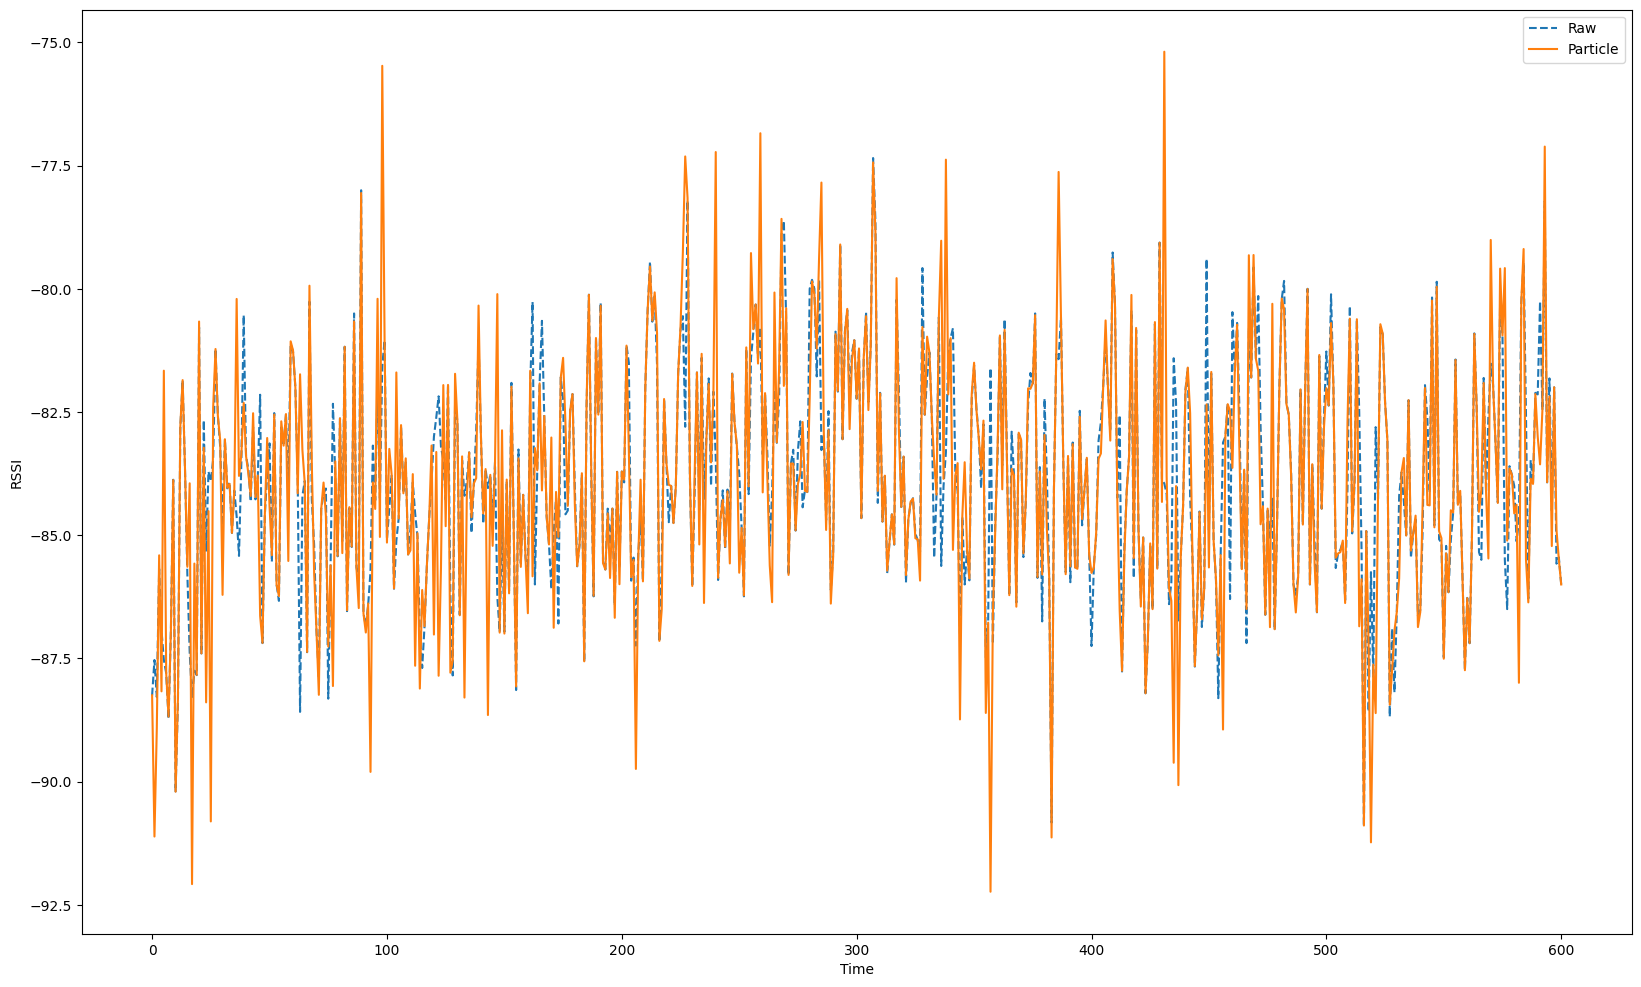

In [18]:
plt.figure(figsize=(20, 12))

plt.plot(df['rssi'], linestyle='dashed', label='Raw')
plt.plot(particle_filtered['rssi'], label='Particle')

plt.legend()
plt.xlabel('Time')
plt.ylabel('RSSI')

The figure shows that the Particle filter is not able to mitigate the signal fluctuations. It introduces peaks when the signal rapidly changes and is also the slowest to compute. Even tuning the parameter, the performance does not improve.

## Filters comparison

We compare the data obtained from each filter implemented.

In [ ]:
plt.figure(figsize=(20, 12))

plt.plot(df['rssi'], linestyle='dotted', label='Raw')
plt.plot(grey_filtered['rssi'],  label='Grey')
plt.plot(kalman_filtered['rssi'], ls='dashed', label='Kalman')
plt.plot(fft_filtered['rssi'], ls='dashdot',label='Fourier')
plt.plot(particle_filtered['rssi'], ls='dotted', color='y', label='Particle')

plt.legend()
plt.xlabel('Time')
plt.ylabel('RSSI')

The comparison confirms the comments made before. The Kalman and Fourier filters are the most promising, being able to smooth quite well the signal. The grey filter is able to mitigate the fluctuations in most cases but sometimes tends to introduce a new one when the signal has rapid changes. Finally, the particle filter performs the worst showing more fluctuations than the raw data.

We perform another comparison, including only the Kalman and the Fourier filters and dropping the less effective ones.

In [ ]:
plt.figure(figsize=(20, 12))

plt.plot(df['rssi'], ls='dotted', label='Raw')
plt.plot(kalman_filtered['rssi'], linestyle='dashed', label='Kalman')
plt.plot(fft_filtered['rssi'], linestyle='solid', label='Fourier')

plt.legend()
plt.xlabel('Time')
plt.ylabel('RSSI')

The Kalman and the Fourier filters provide the best results. The Kalman algorithm is able to follow the actual RSSI value better, while the Fourier grants the smoothest line. The choice of which filters to use depends on the application requirements and the context.